#HW 2 - Image Filtering (10 pts)
---
For homework assignment HW 2, you will implement some image filters, understand convolution and correlation, and understand the nature of different filters. Feel free to use any necessary function from NumPy, but you cannot just import an advanced library and call existing advanced functions by using only one or two lines of code.

Hint for color image filterings: a filter that works on a single intensity channel (grayscale) can be extended to color channels by treating each color channel (R, G, and B) as an independent grayscale image.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from PIL import Image
import cv2

Load image and display it. Feel free to load any image you want, but remember to submit your image if you don't use the image that comes with the assignment.

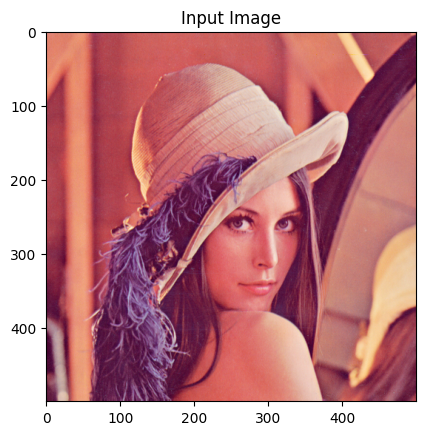

In [3]:
filename = 'Lenna.png'
img_raw = cv2.imread(filename)
H, W, C = img_raw.shape
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
plt.title("Input Image")
plt.imshow(img)
plt.show()



###Task 1 (2 pts)

Implement Gaussian filter to blur the original input image:
1. Select the ideal kernal size separately for sigma=3, 4, 5, 6.
2. Apply Gaussian blurring to the input image with sigma=3, 4, 5, 6 and their corresponding kernel sizes, and visualize all four blurred results.
3. The resulting images have be blurred color images.

(Feel free to change the starter code, or use completely different code)

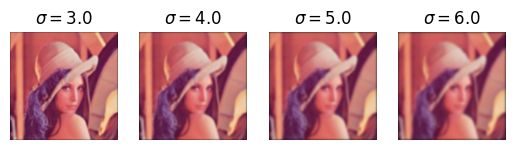

In [4]:
def gaussian_filter(sigma, size):
    # Create coordinate grid
    ax_range = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(ax_range, ax_range)

    # Calculate Gaussian
    kernel = np.exp(-(x**2 + y**2) / (2*sigma**2))
    kernel = kernel / kernel.sum()                  # normalize [0, 1]

    return x, y, kernel

def gaussian_blur(rgb, sigma):
    sh, sw, sc = rgb.shape
    k = 2*int(np.ceil(3*sigma)) + 1

    # Zero pad image
    padded_img = np.pad(rgb, ((k // 2, k // 2), (k // 2, k // 2), (0, 0)), mode='constant')

    # Convert to float
    padded_img = padded_img.astype(np.float64)

    _, _, kernel = gaussian_filter(sigma, k)

    # No flip needed for gaussian [h(x) = h(-x)]
    # kernel = np.flip(kernel)

    out = np.zeros_like(rgb, dtype=np.float64)

    for y in range(sh):
        for x in range(sw):
            for c in range(sc):
                patch = padded_img[y:y+k, x:x+k, c]

                # Convolve
                out[y, x, c] = np.sum(patch * kernel)

    return out.astype(np.uint8)


ax=plt.subplot(1, 4, 1); ax.imshow(gaussian_blur(img, sigma := 3.0)); ax.set_axis_off(); ax.set_title(rf'$\sigma={sigma}$')
ax=plt.subplot(1, 4, 2); ax.imshow(gaussian_blur(img, sigma := 4.0)); ax.set_axis_off(); ax.set_title(rf'$\sigma={sigma}$')
ax=plt.subplot(1, 4, 3); ax.imshow(gaussian_blur(img, sigma := 5.0)); ax.set_axis_off(); ax.set_title(rf'$\sigma={sigma}$')
ax=plt.subplot(1, 4, 4); ax.imshow(gaussian_blur(img, sigma := 6.0)); ax.set_axis_off(); ax.set_title(rf'$\sigma={sigma}$')

# Jupyter displays the value of the last expression unless the cell's final value is None
plt.show()



###Task 2 (2 pts)

1. Shrink the input image's original dimension to 1/4 (1/4 height and 1/4 width) by Gaussian pyramid (applying Gaussian to the input image and subsampling it by keeping every other pixel for each iteration). You will have to experimentally determine an appropriate value for $\sigma$ that balances image sharpness with the subsampling's aliasing artifacts. Feel free to display multiple results and compare them, or just display the best result in your opinion.

2. Identify a convolution kernal and implement the convolution (not correlation) process to translate the above resized smaller image 2 pixels towards left (<-).

3. The resulting images have to be color images.

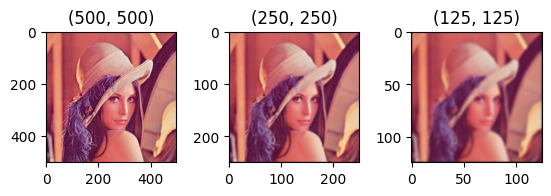

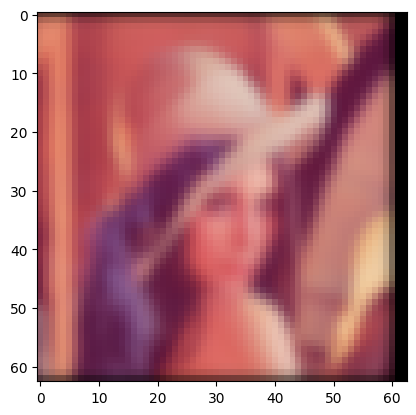

In [5]:
# Resize
def gaussian_pyramid(rgb, levels, sigma=1.0):
    level_img = rgb.copy()

    for level in range(levels + 1):
        ax = plt.subplot(1, levels + 1, level + 1)
        ax.imshow(level_img)
        ax.set_title(f"{level_img.shape[:2]}")

        # blur to reduce aliasing
        level_img = gaussian_blur(level_img, sigma)

        # subsample
        level_img = level_img[::2, ::2, :]

    return level_img.astype(np.uint8)


sigma = np.sqrt(4.0)
quarter_img = gaussian_pyramid(img, 2, sigma)

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

# kernel and convolution
def conv2d(src, kernel):
    sh, sw, sc = src.shape
    kh, kw = kernel.shape

    kernel_flipped = np.flip(kernel)

    padded_img = np.pad(src, ((kh // 2, kh // 2), (kw // 2, kw // 2), (0, 0)), mode='constant')

    out = np.zeros_like(src)

    for y in range(sh):
        for x in range(sw):
            for c in range(sc):
                out[y, x, c] = np.sum(padded_img[y:y+kh, x:x+kw, c] * kernel_flipped)

    return out

h_shift = np.zeros((5, 5))
h_shift[2, 0] = 1
shifted_img = conv2d(quarter_img, h_shift)
plt.imshow(shifted_img)
plt.show()


###Task 3 (2 pts)

Implement the matching using Normalized Cross-Correlation (NCC) to locate the face within the source image. Use the cropped face from your HW1 as the template for template matching. Visualize the resulting NCC map as a grayscale or pseudo-color heat map. Highlight the detected region in the original image using a bounding box (or anything reasonable/intuitive) at the location of the maximum correlation peak.



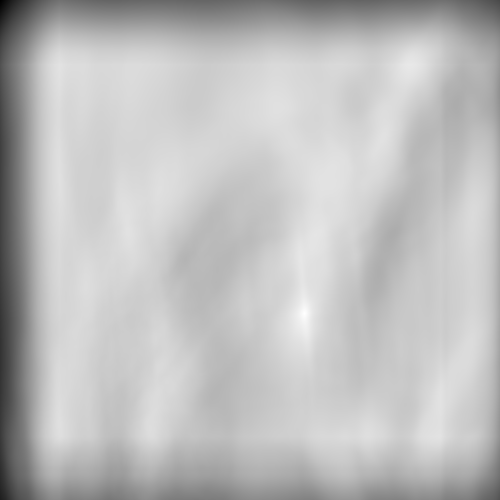

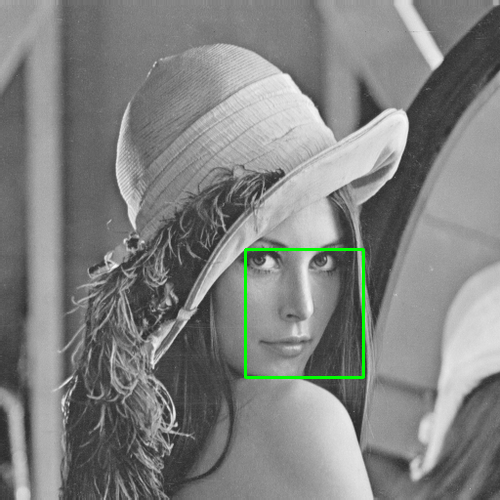

In [9]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow

# ncc generates a score map with the same dimension as src
# each cell contains the score value for that particular coordinate
def ncc(src, template):
    sh, sw = src.shape
    th, tw = template.shape
    # insert your code

    # padding
    # padded_img = xxxx

    padded_img = np.pad(src, ((th//2, th//2), (tw//2, tw//2)), mode='constant') # pad with zeros


    # Note: you might have to convert color value to float for math
    padded_img = padded_img.astype(np.float32)
    tmp = template.astype(np.float32)


    # The result size after padding matches the original image size
    res_h, res_w = src.shape
    score_map = np.zeros((res_h, res_w))

    # For small templates, sliding_window_view + vectorized ops are faster.
    # For large templates, the windows array (H * W * th * tw) is memory bound,
    # and the loops become (much) faster.
    # windows = np.lib.stride_tricks.sliding_window_view(padded_img, window_shape=(th, tw), axis=(0, 1))
    # score_map = np.sum(windows * template, axis=(-1, -2)) / (np.sqrt(np.sum(windows**2, axis=(-1, -2)) * np.sum(template**2)))

    # sliding window process
    for y in range(res_h):
        for x in range(res_w):
            # extract the region of interest from the padded image
            patch = padded_img[y:y+th, x:x+tw]

            score_map[y, x] = np.sum(patch * tmp) / (np.sqrt(np.sum(patch**2) * np.sum(tmp**2)))

    return score_map

# visualize the score map from NCC
def visualize_scoremap(score_map):
    # Normalize the score map float to 0-255
    # NORM_MINMAX makes the highest score 255
    norm = cv2.normalize(score_map, None, 0, 255, cv2.NORM_MINMAX)

    # convert to grayscale uint8
    heatmap = norm.astype(np.uint8)

    return heatmap

# Load darkened or brightened Lenna.png from your HW 1
# You can load the darkened or brightened image directly
# or copy and paste your HW 1 code here to darken/brighten the Lenna image as the main_image
# main_image = cv2.imread('Lenna_brightened.png')

def adjust_brightness(img, value):
    # Convert to 32-bit before adding value to prevent underflow/overflow
    out = img.astype(np.int32) + int(value)

    # Clamp to 8-bit range
    out[out < 0] = 0
    out[out > 255] = 255

    # Return 8-bit
    return out.astype(np.uint8)

main_image = adjust_brightness(img, 20)

# template: crop the face from the original Lenna image
template = img[249:377, 245:364]

# convert main_image and template to grayscale
main_image = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# get score_map by ncc
score_map = ncc(main_image, template)

# Find the best match coordinates
y, x = np.unravel_index(np.argmax(score_map), score_map.shape)

kernel, w = template.shape
top_left = (x - w//2, y - kernel//2)
bottom_right = (x + w//2, y + kernel//2)

# Visualize the matching box on top of the main image
output = cv2.cvtColor(main_image, cv2.COLOR_GRAY2BGR)
cv2.rectangle(output, top_left, bottom_right, (0, 255, 0), 2)

# Visualize the scoremap that is calculated from NCC
heatmap = visualize_scoremap(score_map)
# cv2_imshow(heatmap)
# cv2_imshow(output)
plt.subplot(1, 2, 1).imshow(heatmap)
plt.subplot(1, 2, 2).imshow(output)
plt.show()


###Task 4 (2 pts)

Identify and implement the most effective spatial filter discussed in class to remove the salt&pepper noise in image "Lenna_noise.png". The resulting image has to be a color image.

In [ ]:
def median_filter_np(image, k):
    radius = k//2

    # Pad with zeros
    padded = np.pad(image, ((radius, radius), (radius, radius), (0, 0)), mode='constant')
    # padded shape: (H+k, W+k, 3)

    windows = np.lib.stride_tricks.sliding_window_view(
        padded,
        (k, k),
        axis=(0, 1), # Slide k*k over height and width
    )

    # windows shape: (H+k, W+k, 3, k, k)

    # Median of last two axises
    return np.median(windows, axis=(-1, -2))#.astype(np.uint8)



def median_filter_sort(image, k):
    radius = k//2

    # Pad with zeros
    padded = np.pad(image, ((radius, radius), (radius, radius), (0, 0)), mode='constant')
    # padded shape: (H+2*radius, W+2*radius, 3)

    windows = np.lib.stride_tricks.sliding_window_view(
        padded,
        (k, k),
        axis=(0, 1), # Slide k*k window over height and width
    )
    # windows shape: (H, W, 3, k, k)


    flat = windows.reshape(*windows.shape[:3], -1) # flatten the filters
    sorted = np.sort(flat, axis=-1)                 # sort the filters



    # if k%2 == 0:
    #     avg = (sorted[:,:,:,sorted.shape[-1]//2-1] + sorted[:,:,:,sorted.shape[-1]//2])/2
    #     return avg
    # else:
    return sorted[:,:,:,sorted.shape[-1]//2]




def median_filter_partition(image, k):
    radius = k//2

    # Pad with zeros
    padded = np.pad(image, ((radius, radius), (radius, radius), (0, 0)), mode='constant')
    # padded shape: (H+2*radius, W+2*radius, 3)

    windows = np.lib.stride_tricks.sliding_window_view(
        padded,
        (k, k),
        axis=(0, 1), # Slide k*k window over height and width
    )
    # windows shape: (H, W, 3, k, k)

    flat = windows.reshape(*windows.shape[:3], -1)              # flatten and
    parted = np.partition(flat, flat.shape[-1]//2, axis=-1)     # rearrange the filters
    medians = parted[..., parted.shape[-1]//2]                  # for the middle value

    return medians


import time
salt_and_peppered = plt.imread('Lenna_noise.png')

t0=time.perf_counter(); image_median_sorted = median_filter_sort(salt_and_peppered, k=3); t1=time.perf_counter(); print("sort time:", t1-t0)


t0=time.perf_counter(); image_median_partitioned = median_filter_partition(salt_and_peppered, k=3); t1=time.perf_counter(); print("paritioned time:", t1-t0)


t0=time.perf_counter(); image_median_np = median_filter_np(salt_and_peppered, k=3); t1=time.perf_counter(); print("np time:", t1-t0)

if np.array_equal(image_median_sorted, image_median_np):
    print('Sorted Success!')
else:
    print('Sorted Failed :(')


if np.array_equal(image_median_partitioned, image_median_np):
    print('Partitioned Success!')
else:
    print('Partitioned Failed :(')

plt.subplot(1, 2, 1); plt.imshow(salt_and_peppered); plt.title('salt and peppered')

plt.subplot(1, 2, 2); plt.imshow(image_median_sorted); plt.title('median filter');

plt.show()


In [ ]:
a = np.arange(0,16)
print(f"{a.shape=}")
print(a)
print(f"{np.median(a)=}")

a_middle = a.shape[-1]//2
a_median = (a[a_middle-1]+a[a_middle])/2    # for zero-based indexing (a[middle-1]+a[middle])/2
print(f"{a_median=}")

###Task 5 (2 pts)

Identify and implement the most effective spatial filter discussed in class to remove the freckles but preserve the edges in image "Face_freckles.jpeg". The resulting image has to be a color image. (You will likely have to experimentally determine an appropriate value for some of the parameters. Feel free to display multiple results and compare them, or just display the best result in your opinion.)

In [ ]:
def bilateral_gaussian_blur(image, sigma_s=1.0, sigma_r=1.0):
    if image.ndim > 2:
        out = np.zeros_like(image)
        out[:, :, 0] = bilateral_gaussian_blur(image[:, :, 0], sigma_s, sigma_r)
        out[:, :, 1] = bilateral_gaussian_blur(image[:, :, 1], sigma_s, sigma_r)
        out[:, :, 2] = bilateral_gaussian_blur(image[:, :, 2], sigma_s, sigma_r)
        return out

    k = 2 * int(np.ceil(3*sigma_s)) + 1                       # sigma_r is in intensity space, not spatial space
    radius = k//2

    x_mesh, y_mesh = np.meshgrid(np.arange(-radius, radius+1),
                                 np.arange(-radius, radius+1),
                                 indexing='xy')
    image_float = image.astype(np.float64)

    G_s = np.exp(-((x_mesh**2 + y_mesh**2)/(2*sigma_s**2)))   # spatial: how close?

    padded = np.pad(image_float, radius, mode="constant")

    out = np.zeros_like(image, dtype=np.float64)

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):

            patch = padded[y:y+k, x:x+k]

            diff = patch - image_float[y, x]
            G_r = np.exp(-((diff**2)/(2*sigma_r**2)))       # range (intensity): how similar?
            W = G_s * G_r

            # Not convolution: no kernel flip [h(x) = h(-x) anyway]

            out[y, x] = (patch * W).sum() / W.sum()


    return np.rint(out).clip(0, 255).astype(np.uint8)


rgb = plt.imread('Face_freckles.jpeg')

ax = plt.subplot(1, 3, 1);
ax.imshow(rgb);
ax.set_axis_off()

out_30 = bilateral_gaussian_blur(rgb, sigma_s := 4.0, sigma_r := 30.0)

ax = plt.subplot(1, 3, 2);
ax.imshow(out_30);
ax.set_axis_off();
plt.title(rf'$\sigma_s={sigma_s:.0f}, \sigma_r={sigma_r:.0f}$')

out_80 = bilateral_gaussian_blur(rgb, sigma_s := 4.0, sigma_r := 80.0)

ax = plt.subplot(1, 3, 3);
ax.imshow(out_80);
ax.set_axis_off();
plt.title(rf'$\sigma_s={sigma_s:.0f}, \sigma_r={sigma_r:.0f}$')

plt.show()




